In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.interpolate import interp2d
from scipy.signal import cwt, morlet2
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D)

from BandpassFilter import bandpass_filter

-----------------------------------------------------------------------------------------
                                                                             Defining the AI model
-----------------------------------------------------------------------------------------

In [2]:
class CNN(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.network = tf.keras.Sequential([
            Conv2D(96, (5,5), activation='relu', input_shape=(32,32,1)),
            BatchNormalization(),
            MaxPool2D(strides=1),
            Dropout(0.2),
            Conv2D(32, (5,5), activation='relu'),
            MaxPool2D(strides=2),
            Dense(500),
            Flatten(),
            Dense(2, activation='softmax')
        ])
    
    def call(self, x):
        return self.network(x)

-----------------------------------------------------------------------------------------
                                                                                Processing the Data
-----------------------------------------------------------------------------------------

In [2]:
def get_data(folder, fileno):

    filename = f"{folder}00{fileno}" if fileno < 10 else f"{folder}0{fileno}" if 10<=fileno<=99 else f"{folder}{fileno}"
    with open(f'./datasets/Bonn/{folder}/{filename}.txt', 'r') as signal_file:
        data = np.array([int(x) for x in signal_file.read().split('\n')[:-1]])
    
    return data

In [4]:
fs = 173.6
WIDTH_LENGTH, WIDTH_PATTERN = 100, 2

freqs = np.linspace(1, fs/2, WIDTH_LENGTH)
widths = (6*fs)/(2*freqs*np.pi)

x = np.empty((500, WIDTH_LENGTH, 4097), dtype=np.complex128)
y = np.zeros(500, dtype=np.uint8)

idx = 0

for folder in 'ZONFS':
    for filename in range(1, 101):
        data = get_data(folder, filename)
        data = bandpass_filter(data, 173.6, 0.53, 40)
        x[idx] = cwt(data, morlet2, widths)

        if folder == 'S':
            y[idx] = 1

        idx += 1

In [5]:
y_vals = np.arange(WIDTH_LENGTH)
x_vals = np.arange(4097)

x_resized = np.empty((500,32,32), dtype=np.complex128)

for idx, image in enumerate(x):
    f_real = interp2d(x_vals,y_vals,image.real,kind='cubic')
    f_imag = interp2d(x_vals,y_vals,image.imag,kind='cubic')
    y_new = np.linspace(0, WIDTH_LENGTH, 32)
    x_new = np.linspace(0, 4097, 32)
    x_resized[idx].real = f_real(x_new, y_new)
    x_resized[idx].imag = f_imag(x_new, y_new)

x_train, x_test, y_train, y_test = train_test_split(x_resized, y, test_size=0.2, stratify=y)

-----------------------------------------------------------------------------------------
                                                                               Training the Model
-----------------------------------------------------------------------------------------

In [6]:
CNN_model = CNN()
CNN_model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [7]:
history = CNN_model.fit(x_train, y_train, batch_size=4, epochs=50, validation_data=(x_test, y_test), shuffle=True, verbose=0)

In [8]:
model_name = f'CNNSM-wp{WIDTH_PATTERN}-wl{WIDTH_LENGTH}-A'
CNN_model.save(f'./models/{model_name}')

INFO:tensorflow:Assets written to: ./models/All sets/optimised/CNNSM-wp2-wl100-A\assets


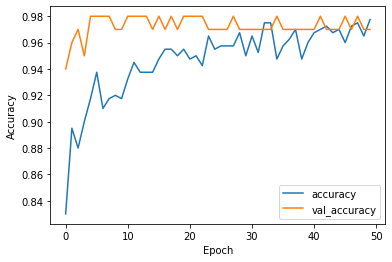

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(f'./models/{model_name}.jpg')
plt.show()

-------------
                                                                                Testing the model
-------------                                                                                

In [14]:
y_pred = CNN_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp/(tp+fp)
specificity = tn/(fp+tn)

In [15]:
print(f'{accuracy=}')
print(f'{sensitivity=}')
print(f'{specificity=}')
print(f'{precision=}')
print(f'{recall=}')
print(f'{fscore=}')
print(f'{tp=}\n{tn=}\n{fp=}\n{fn=}')

accuracy=0.97
sensitivity=0.9473684210526315
specificity=0.9875
precision=0.9473684210526315
recall=0.9
fscore=0.9230769230769231
tp=18
tn=79
fp=1
fn=2


---------------------------
                                                                                Loading a saved model
---------------------------                                                                                    

In [ ]:
model_path = './optimised model'
loaded_model = tf.keras.models.load_model(model_path)

y_pred = loaded_model.predict(x_test)  # run cells 4 and 5 to obtain the data
y_pred = np.argmax(y_pred, axis=1)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp/(tp+fp)
specificity = tn/(fp+tn)

print(f'{accuracy=}')
print(f'{sensitivity=}')
print(f'{specificity=}')
print(f'{precision=}')
print(f'{recall=}')
print(f'{fscore=}')
print(f'{tp=}\n{tn=}\n{fp=}\n{fn=}')